# Car generator (GAN)

## Imports

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms, models
import torch.nn as nn
from torchvision.utils import save_image

import numpy as np

import matplotlib.pyplot as plt

/home/arturo/PythonEnvs/mlenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Loading the dataset

In [81]:
transform = transforms.Compose([
    transforms.Resize(96),
    transforms.CenterCrop((96,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset_train = datasets.ImageFolder('./dataset/train', transform=transform)
dataset_test = datasets.ImageFolder('./dataset/test', transform=transform)

whole_dataset = torch.utils.data.ConcatDataset([dataset_train, dataset_test])

In [82]:
def show_car(image):
    plt.imshow(image.permute(1,2,0))
    plt.xticks([])
    plt.yticks([])

In [83]:
batch_size = 32

data_loader = torch.utils.data.DataLoader(whole_dataset, batch_size=batch_size,shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


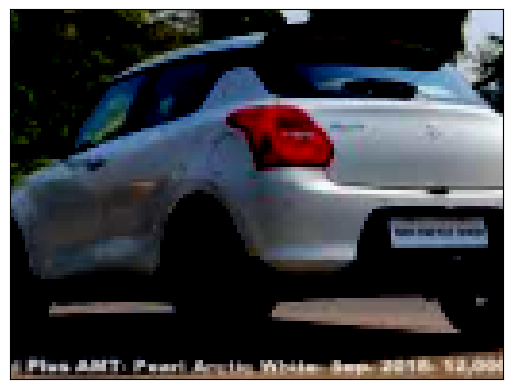

In [84]:
images, _ = next(iter(data_loader))

show_car(images[13])

In [85]:
images[13]

tensor([[[ 0.1373, -0.2157, -0.2000,  ...,  0.7961,  0.7961,  0.7961],
         [ 0.0667,  0.0275, -0.0902,  ...,  0.7882,  0.7882,  0.7882],
         [ 0.0667,  0.1216, -0.0745,  ...,  0.7804,  0.7882,  0.7882],
         ...,
         [ 0.5451,  0.5529,  0.3412,  ...,  0.8353,  0.7255,  0.8275],
         [ 0.5451,  0.4745,  0.3255,  ...,  0.6000,  0.5059,  0.6078],
         [ 0.5294,  0.4745,  0.4980,  ...,  0.5294,  0.5373,  0.5373]],

        [[ 0.2157, -0.1294, -0.0902,  ...,  0.8510,  0.8510,  0.8510],
         [ 0.1451,  0.1137,  0.0196,  ...,  0.8431,  0.8431,  0.8431],
         [ 0.1373,  0.2078,  0.0275,  ...,  0.8275,  0.8353,  0.8353],
         ...,
         [ 0.4980,  0.5137,  0.2941,  ...,  0.7490,  0.6235,  0.7490],
         [ 0.4667,  0.3882,  0.2392,  ...,  0.4902,  0.3961,  0.5059],
         [ 0.4275,  0.3725,  0.3961,  ...,  0.4039,  0.4118,  0.4118]],

        [[-0.2549, -0.5608, -0.3804,  ...,  0.9294,  0.9294,  0.9294],
         [-0.3255, -0.3098, -0.2706,  ...,  0

In [86]:
latent_dim = 100
img_shape = (3, 96, 128)
n_epochs = 100

## Defining the model

In [87]:
#Hout​=(Hin​−1)×stride[0]−2×padding[0]+kernel_size[0]
#Wout​=(Win​−1)×stride[1]−2×padding[1]+kernel_size[1]

#Example:
#Image is 3x4
#Kernel is 3x4
#Stride is 2x2
#Padding is 1x1
#
#H = (3-1)*2 - 2*1 + 4 = 6
#W = (4-1)*2 - 2*1 + 4 = 8

#H = (6-1)*2 - 2*1 + 4 = 12
#W = (8-1)*2 - 2*1 + 4 = 16
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.relu = nn.ReLU(True)

        #INPUT: 100 x 1 x 1
        self.trans1 = nn.ConvTranspose2d(latent_dim, 256, kernel_size=(3,4), stride=(1,1), padding=(0,0), bias=False)
        self.bn1 = nn.BatchNorm2d(256)

        #INPUT: 256 x 3 x 4
        self.trans2 = nn.ConvTranspose2d(256, 128, kernel_size=(4,4), stride=(2,2), padding=(1,1), bias=False) 
        self.bn2 = nn.BatchNorm2d(128)

        #INPUT: 128 x 6 x 8
        self.trans3 = nn.ConvTranspose2d(128, 64, kernel_size=(4,4), stride=2, padding=1, bias=False) 
        self.bn3 = nn.BatchNorm2d(64)

        #INPUT: 64 x 12 x 16
        self.trans4 = nn.ConvTranspose2d(64, 32, kernel_size=(4,4), stride=2, padding=1, bias=False) 
        self.bn4 = nn.BatchNorm2d(32)
        
        #INPUT: 32 x 24 x 32
        self.trans5 = nn.ConvTranspose2d(32, 16, kernel_size=(4,4), stride=2, padding=1, bias=False) 
        self.bn5 = nn.BatchNorm2d(16)

        #INPUT: 16 x 48 x 64
        self.trans6 = nn.ConvTranspose2d(16, 3, kernel_size=(4,4), stride=2, padding=1, bias=False) 
        self.sigmoid = nn.Sigmoid() 

        #FINAL: 3 x 96 x 128

    def forward(self, z):
        z = self.trans1(z)
        z = self.bn1(z)
        z = self.relu(z)

        z = self.trans2(z)
        z = self.bn2(z)
        z = self.relu(z)

        z = self.trans3(z)
        z = self.bn3(z)
        z = self.relu(z)
        
        z = self.trans4(z)
        z = self.bn4(z)
        z = self.relu(z)

        z = self.trans5(z)
        z = self.bn5(z)
        z = self.relu(z)

        z = self.trans6(z)
        z = self.sigmoid(z)
        
        return z.view(-1, *img_shape)

In [88]:
z.shape

torch.Size([32, 100, 1, 1])

In [94]:
#Hout​=⌊(Hin​+2×padding[0]−kernel_size[0]​)/stride[0] + 1⌋

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.leaky = nn.LeakyReLU(0.2)

        #INPUT: 3 x 96 x 128
        self.conv1 = nn.Conv2d(3,32,kernel_size=4,stride=2,padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        #INPUT: 32 x 48 x 64
        self.conv2 = nn.Conv2d(32,64,kernel_size=4,stride=2,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(64)

        #INPUT: 64 x 24 x 32
        self.conv3 = nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False)
        self.bn3 = nn.BatchNorm2d(128)

        #INPUT: 128 x 12 x 16
        self.conv4 = nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False)
        self.bn4 = nn.BatchNorm2d(256)

        #INPUT: 256 x 6 x 8
        self.conv5 = nn.Conv2d(256,1,kernel_size=(6,8),stride=1,padding=0,bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        z = self.conv1(z)
        z = self.bn1(z)
        z = self.leaky(z)

        z = self.conv2(z)
        z = self.bn2(z)
        z = self.leaky(z)

        z = self.conv3(z)
        z = self.bn3(z)
        z = self.leaky(z)

        z = self.conv4(z)
        z = self.bn4(z)
        z = self.leaky(z)
        
        z = self.conv5(z)
        z = self.sigmoid(z)
        return z

In [95]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [96]:
lr = 1e-3
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

criterion = nn.BCELoss()

In [98]:
for epoch in range(n_epochs):
    epoch_g_losses = []
    epoch_d_losses = []
    
    for i, (imgs, _) in enumerate(data_loader):
        # Create fake images

        z = torch.Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim)))
        z = torch.unsqueeze(z,2)
        z = torch.unsqueeze(z,3)
        z = z.to(device)
        
        fake_imgs = generator(z)
        
        # Discriminator training

        optimizer_D.zero_grad()

        imgs = imgs.to(device)
        targets_real = torch.ones(imgs.size(0), 1, 1, 1).to(device)
        targets_fake = torch.zeros(imgs.size(0), 1, 1, 1).to(device)
        
        real_img_loss = criterion(discriminator(imgs), targets_real)
        fake_img_loss = criterion(discriminator(fake_imgs), targets_fake)

        real_img_loss.backward()
        fake_img_loss.backward()
        
        optimizer_D.step()

        epoch_d_losses.append(d_loss.item())

        # Generator training
        
        optimizer_G.zero_grad()

        targets = torch.ones(imgs.size(0), 1, 1, 1)
        targets = targets.to(device)

        g_loss = criterion(discriminator(fake_imgs.detach()), targets)

        g_loss.backward()
        optimizer_G.step()

        epoch_g_losses.append(g_loss.item())

    print(
        f"[Epoch {epoch}/{n_epochs}] [G loss: {sum(epoch_g_losses)/len(epoch_g_losses)}] [D loss: {sum(epoch_d_losses)/len(epoch_d_losses)}]"
    )
    save_image(fake_imgs.data[:5], f"./result/fake_{epoch}.png", nrow=5, normalize=True)
    save_image(imgs.data[:5], f"./result/real_{epoch}.png", nrow=5, normalize=True)

[Epoch 0/100] [G loss: 11.866769160933167] [D loss: 50.0]
[Epoch 1/100] [G loss: 13.47618207858719] [D loss: 50.0]
[Epoch 2/100] [G loss: 14.011237690466961] [D loss: 50.0]
[Epoch 3/100] [G loss: 14.44548283642485] [D loss: 50.0]
[Epoch 4/100] [G loss: 14.778394109420194] [D loss: 50.0]
[Epoch 5/100] [G loss: 15.052510742012782] [D loss: 50.0]
[Epoch 6/100] [G loss: 15.29038779426167] [D loss: 50.0]
[Epoch 7/100] [G loss: 15.514715849898243] [D loss: 50.0]
[Epoch 8/100] [G loss: 15.709627646526307] [D loss: 50.0]
[Epoch 9/100] [G loss: 15.863696768083646] [D loss: 50.0]
[Epoch 10/100] [G loss: 16.04567545242892] [D loss: 50.0]
[Epoch 11/100] [G loss: 16.19175913133694] [D loss: 50.0]
[Epoch 12/100] [G loss: 16.32007042688268] [D loss: 50.0]
[Epoch 13/100] [G loss: 16.451538013137935] [D loss: 50.0]
[Epoch 14/100] [G loss: 16.5789164186434] [D loss: 50.0]
[Epoch 15/100] [G loss: 16.71219017669445] [D loss: 50.0]
[Epoch 16/100] [G loss: 16.817139603709446] [D loss: 50.0]
[Epoch 17/100] [